In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/SMBUD/')

In [ ]:
!pip install ydata_profiling sweetviz lux-api autoviz plotly matplotlib typing_extensions

In [4]:
import pandas as pd
import json
from ydata_profiling import ProfileReport
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples

# Neo4j

## User analysis

In [57]:
df = pd.read_csv('/content/drive/MyDrive/SMBUD/Instagram_User_Stats.csv')

In [58]:
df

user_id  num_posts  num_followers  num_following  engagement_grade  \
0            1        702            906            677            0.1891   
1            2        160            386            713            0.1950   
2            3        851          20400           3700            0.0664   
3            4         42            900           7500            0.0592   
4            5         50            486           4350            0.5112   
...        ...        ...            ...            ...               ...   
70404    70405         78            149            199            0.2497   
70405    70406         27             64             48            0.4511   
70406    70407         85            506            652            0.1201   
70407    70408         57            107             31            0.4222   
70408    70409         53            208            336            0.2713   

       engagement_rate  followers_growth_per_month  outsiders_percentage  
0             6.070640                    1.177860               14.8936  
1             6.260800                    0.094127               16.9811  
2             0.717416                    2.242440               38.2166  
3             1.901230                    7.643310               60.1626  
4            16.409500                    0.372900               61.9403  
...                ...                         ...                   ...  
70404         8.016400                    0.410959               45.0704  
70405        14.479200                    0.970664               10.3448  
70406         3.853750                    0.000000               43.1507  
70407        13.551400                   -1.675880               42.3729  
70408         8.707260                    0.590125               38.3562  

[70409 rows x 8 columns]

In [60]:
#create a profile report in html
PROFILE = ProfileReport(df, title="Pandas Profiling Report")
PROFILE.to_file("/content/drive/MyDrive/SMBUD/Neo4J Dataset Report - User statistics.html")
PROFILE

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Network analysis

In [61]:
file_path = '/content/drive/MyDrive/SMBUD/Network.txt'

delimiter = ' '

# Read the text file into a DataFrame
df = pd.read_csv(file_path, delimiter)

<ipython-input-61-13eb0762dd5e>:6: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df = pd.read_csv(file_path, delimiter)


In [62]:
df

Source  Target  Weight
0             1       2  0.0833
1             1       3  0.0500
2             2      69  0.0005
3             2      72  0.0008
4             2      77  0.0006
...         ...     ...     ...
1031343   70406   20349  0.0526
1031344   70407   19199  0.0588
1031345   70408   54347  0.0833
1031346   70408   54464  0.0588
1031347   70409   45213  0.0909

[1031348 rows x 3 columns]

In [63]:
# scaling the dtaframe
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

### Choosing the right K - Elbow Method

In [ ]:
inertias = []
for k in range(1, 31):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertias.append(kmeans.inertia_)

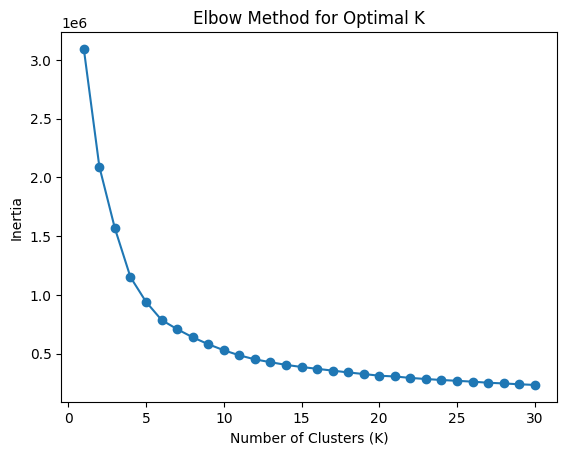

In [10]:
plt.plot(range(1,31), inertias, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.savefig('elbow_method.png', dpi=300)
plt.show()

## Clustering with K = 9

In [64]:
# Performing KMeans clustering with the chosen K
k = 9
kmeans = KMeans(n_clusters=k, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)
df_scaled['Cluster'] = kmeans.fit_predict(df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [66]:
df

Source  Target  Weight  Cluster
0             1       2  0.0833        0
1             1       3  0.0500        0
2             2      69  0.0005        0
3             2      72  0.0008        0
4             2      77  0.0006        0
...         ...     ...     ...      ...
1031343   70406   20349  0.0526        1
1031344   70407   19199  0.0588        1
1031345   70408   54347  0.0833        6
1031346   70408   54464  0.0588        6
1031347   70409   45213  0.0909        6

[1031348 rows x 4 columns]

In [67]:
# Cluster Profiles
cluster_profiles = df.groupby('Cluster').mean()
print("Cluster Profiles:")
print(cluster_profiles)

Cluster Profiles:
               Source        Target    Weight
Cluster                                      
0         9212.493357   7036.064277  0.031100
1        55818.504698  15374.609540  0.034866
2        30742.615496  44614.347596  0.357516
3        16389.030472  48342.384443  0.090895
4        13271.946116  23968.237471  0.056027
5        30608.999807  50285.205405  1.000000
6        53287.786609  49728.096346  0.093442
7        36136.110240  31736.239837  0.050327
8        32303.383051   8652.209701  0.027809


In [68]:
# Cluster Size
cluster_counts = df['Cluster'].value_counts().sort_index()
print("\nCluster Sizes:")
print(cluster_counts)


Cluster Sizes:
0    241547
1    120276
2     36062
3     86866
4    164222
5      5180
6    100056
7    130597
8    146542
Name: Cluster, dtype: int64


In [69]:
# Convert the counts to an array (cluster_sizes) for plotting
cluster_sizes = cluster_counts.values
cluster_sizes

array([241547, 120276,  36062,  86866, 164222,   5180, 100056, 130597,
       146542])

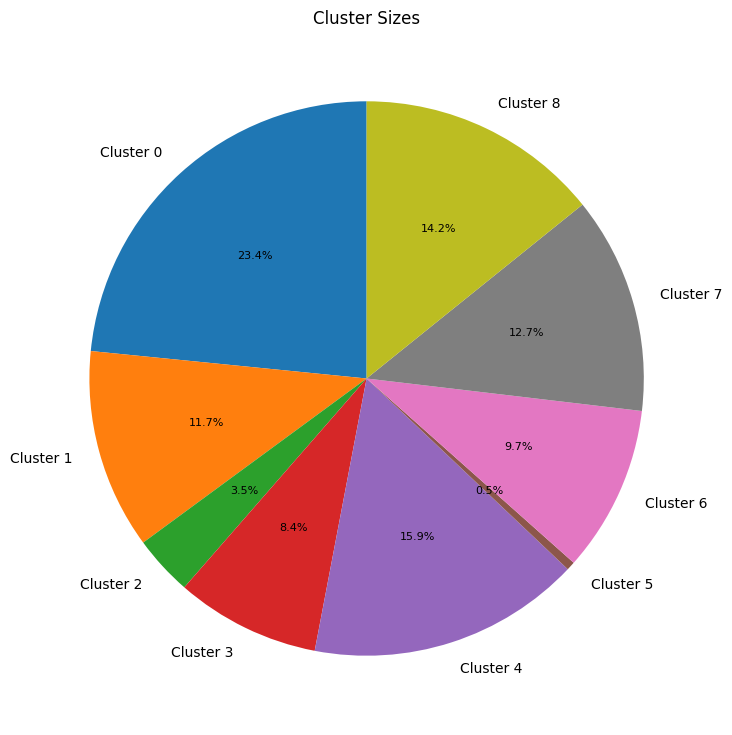

In [70]:
# Provided cluster sizes
cluster_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8']

# Plotting the pie chart with adjustments
plt.figure(figsize=(9, 9))
_, _, autotexts = plt.pie(cluster_sizes, labels=cluster_labels, autopct='%1.1f%%', startangle=90, textprops=dict(fontsize=10))
plt.title('Cluster Sizes')

# Adjust the label font size in the legend
for autotext in autotexts:
    autotext.set_fontsize(8)

# Save the figure with a higher resolution
plt.savefig('pie_chart_cluster_sizes.png', dpi=300)

plt.show()

In [71]:
# Cluster Centroids
cluster_centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=df.columns[:-1])

In [72]:
cluster_centroids

Source        Target    Weight
0   9234.534760   7029.087543  0.031063
1  55840.327453  15421.444379  0.034884
2  30747.084401  44616.568901  0.357504
3  16379.562455  48343.449670  0.090903
4  13253.993001  23945.163666  0.056045
5  30608.999807  50285.205405  1.000000
6  53273.582674  49717.312239  0.093379
7  36067.085025  31723.028847  0.050336
8  32373.182477   8648.357628  0.027819

In [73]:
cluster_profiles

Source        Target    Weight
Cluster                                      
0         9212.493357   7036.064277  0.031100
1        55818.504698  15374.609540  0.034866
2        30742.615496  44614.347596  0.357516
3        16389.030472  48342.384443  0.090895
4        13271.946116  23968.237471  0.056027
5        30608.999807  50285.205405  1.000000
6        53287.786609  49728.096346  0.093442
7        36136.110240  31736.239837  0.050327
8        32303.383051   8652.209701  0.027809

In [74]:
cluster_centroids['Cluster'] = [0,1,2,3,4,5,6,7,8]
cluster_centroids

Source        Target    Weight  Cluster
0   9234.534760   7029.087543  0.031063        0
1  55840.327453  15421.444379  0.034884        1
2  30747.084401  44616.568901  0.357504        2
3  16379.562455  48343.449670  0.090903        3
4  13253.993001  23945.163666  0.056045        4
5  30608.999807  50285.205405  1.000000        5
6  53273.582674  49717.312239  0.093379        6
7  36067.085025  31723.028847  0.050336        7
8  32373.182477   8648.357628  0.027819        8

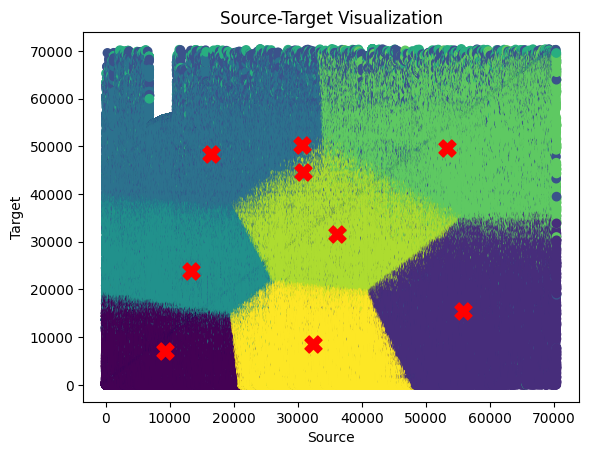

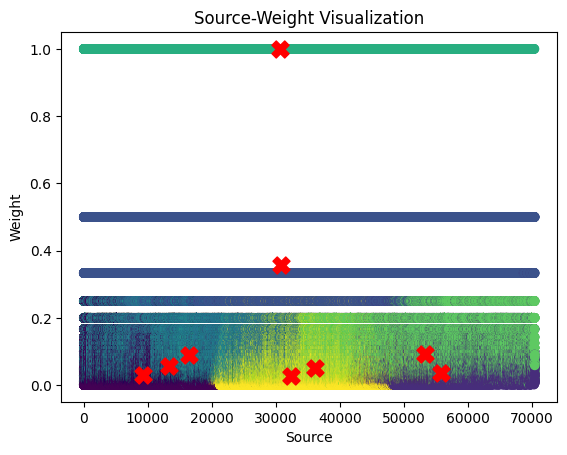

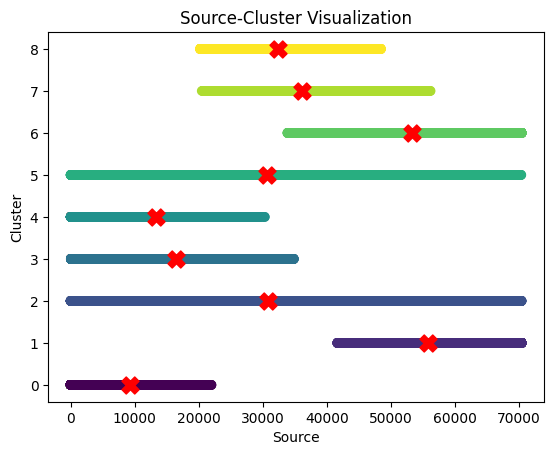

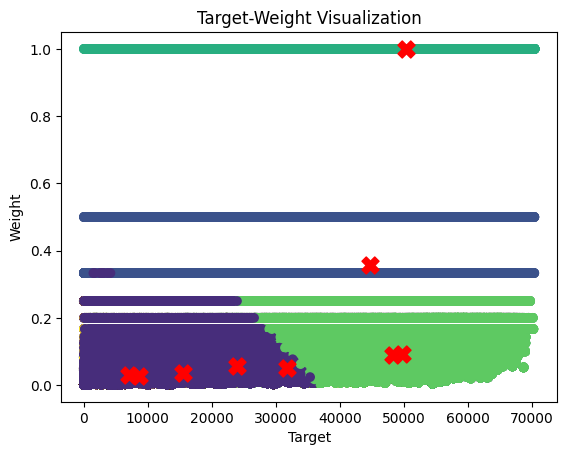

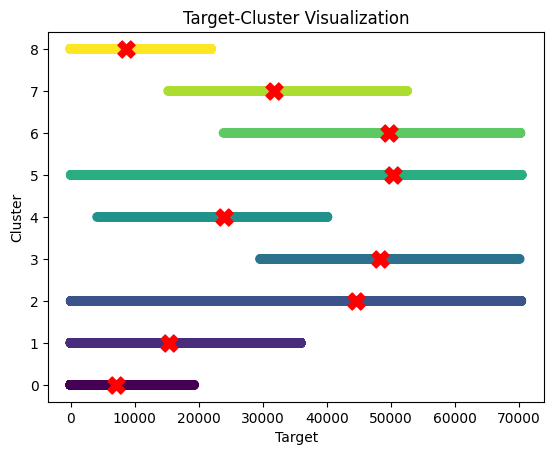

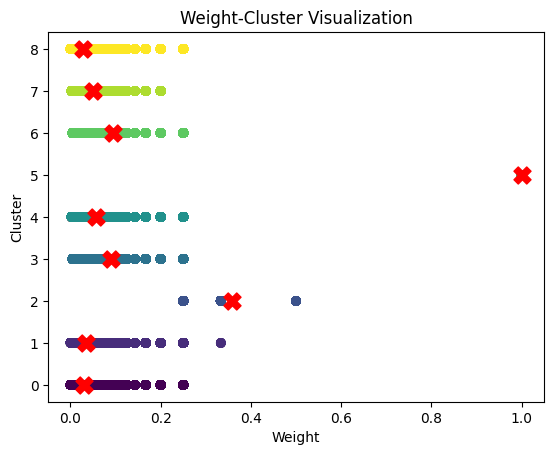

In [75]:
# Visualizing clusters
cols = df.columns.copy()

for idx_i,i in enumerate(cols):
  for idx_j,j in enumerate(cols):
    if idx_j<=idx_i:
      continue
    plt.scatter(df[i], df[j], c=df['Cluster'], cmap='viridis')
    plt.scatter(cluster_centroids[i], cluster_centroids[j], marker='X', s=150, c='red') # 200
    plt.title(str(i) + '-' + str(j) + (' Visualization'))
    plt.xlabel(str(i))
    plt.ylabel(str(j))
    #plt.savefig('cluster_visualization_with_marker-' + str(j) + '_' + str(i) + '.png', dpi=300)
    plt.show()

In [76]:
sampled_df = df_scaled.sample(frac=0.2, random_state=42)

In [77]:
# Compute silhouette scores for each data point
silhouette_values = silhouette_samples(sampled_df, sampled_df['Cluster'])

# Average silhouette score
average_silhouette_score = silhouette_score(sampled_df, sampled_df['Cluster'])

In [78]:
average_silhouette_score

0.5850232532904212

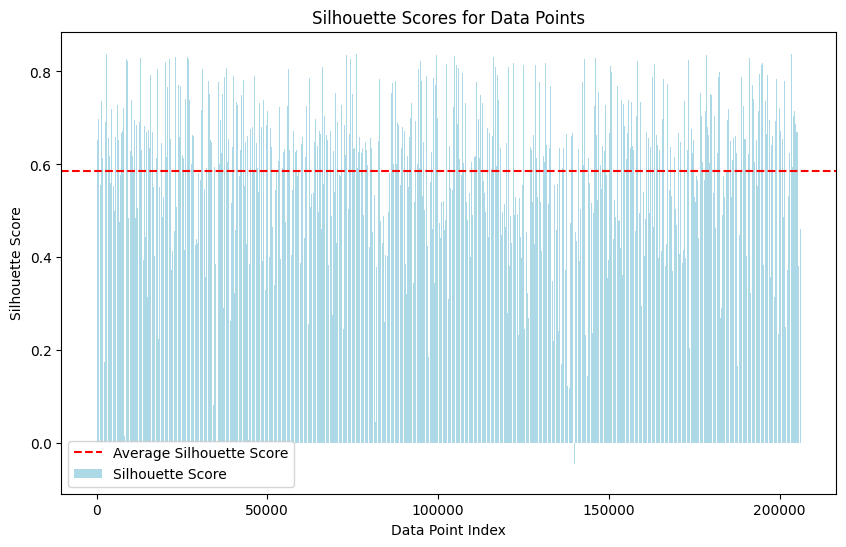

In [80]:
# Create a bar plot of silhouette scores
plt.figure(figsize=(10, 6))
plt.bar(range(len(sampled_df)), silhouette_values, color='lightblue', label='Silhouette Score')
plt.axhline(y=average_silhouette_score, color="red", linestyle="--", label='Average Silhouette Score')

# Add a legend
plt.legend(loc='lower left')

plt.xlabel("Data Point Index")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Data Points")

plt.savefig('silhouette_scores_plot.png', dpi=300)
plt.show()